<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-starmath4/blob/main/Oct12-14/Tarea_7_de_octubre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from re import T
import numpy as np
import emcee

data=np.loadtxt("olympic100m_men.txt",delimiter=",").T #Delimitados por coma ya que es archivo separado por comas, .T indica la transpuesta
data = np.loadtxt("olympic100m_men.txt", delimiter=",").T

# Datos
x = data[0][:]
y = data[1][:]

x = (x - 1896) / 4 #normalizo datos
yerr=0.1

In [ ]:
#Fucniones para el MCMC

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [98]:
#Como primera aproximación para MCMC usaremos el método de mínimos cuadrados

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

#Parametros propuestos
m_true = -0.3
b_true = 10.3
f_true = 0.5

#Generar algunos datos usando el modelo de los parametros propuestos
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [101]:
#Uso método de mínimos cuadrados para estimar los parámetros
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))

print("Estimación de mínimos cuadrados:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

Estimación de mínimos cuadrados:
m = -0.885 ± 0.016
b = 14.522 ± 0.091


Estimación maximizando Likelihood:
m = -0.427
b = 11.245
f = 0.506


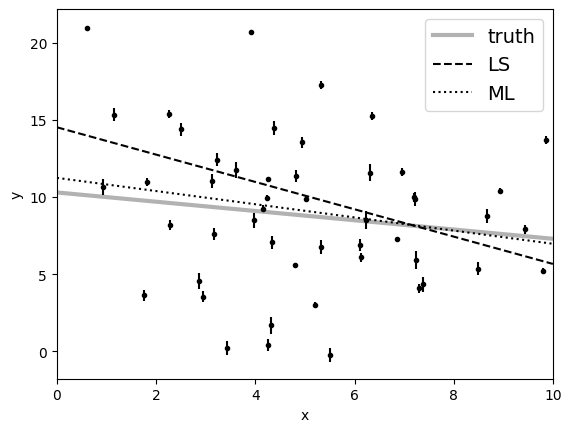

In [102]:
from scipy.optimize import minimize

#Estimo con maximización del likelihood
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Estimación maximizando Likelihood:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

x0 = np.linspace(0, 10, 500)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [85]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3) #Uso 32 cadenas y 3 parametros a estimar
#Nota: Cuando intente usar 4 cadenas me arroja el código que no se puede usar un numero de cadenas menor al doble de las dimensiones
#nwalkers el numero de cadenas
#ndim es el numero de dimensiones
nwalkers, ndim = pos.shape

#Creo el objeto sampler y lo corro
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:03<00:00, 1332.05it/s]


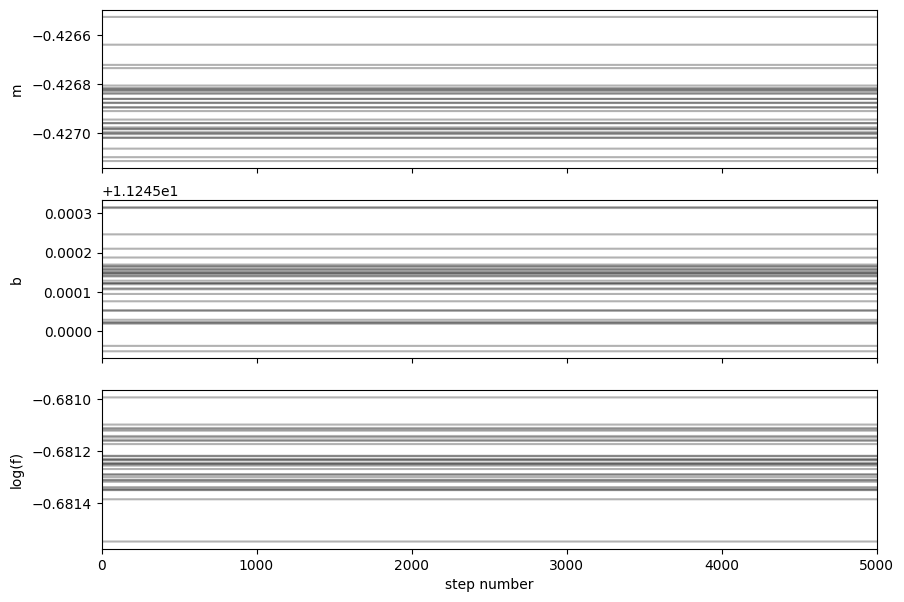

In [86]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(10656, 3)


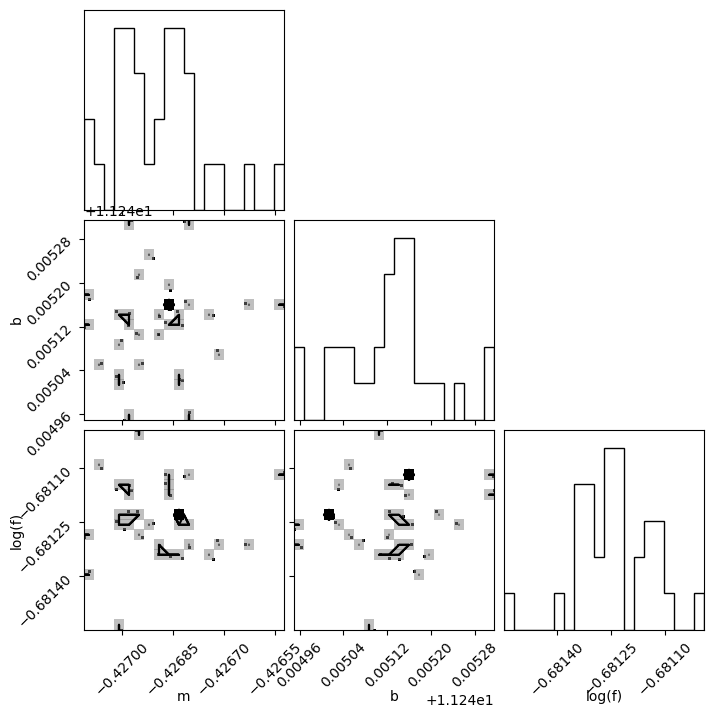

In [97]:
#gráficas para estudiar la convergencia del sistema

flat_samples = sampler.get_chain(discard=0, thin=15, flat=True) #descarto el burn
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

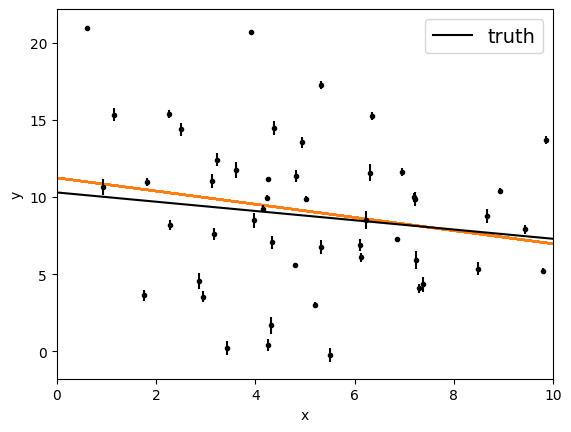

In [94]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");